In [1]:
import pandas as pd
import numpy as np
import json
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans, SpectralClustering
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
# Pour avoir un plot 3D interactif
#%matplotlib widget
np.random.seed(42)

# Préparation des données

In [2]:
files = [
    '../data/data_limagrain_2024/OSR BN51776 lot1.xlsx',
    '../data/data_limagrain_2024/OSR lot 2.xlsx',
    '../data/data_limagrain_2024/OSR Lot 3.xlsx',
    '../data/data_limagrain_2024/OSR lot 4.xlsx'
]

In [3]:
labels = pd.read_excel('../data/data_limagrain_2024/génotypage_correct.xlsx')

In [4]:
df_list = []
for i, f in enumerate(files):
    df_tmp = pd.read_excel(f)
        
    # get seed ID
    df_tmp['ColNr'] = df_tmp['ColNr'].astype('str')
    df_tmp['ColNr'].where(df_tmp['ColNr'].astype('int64')>=10, other='0'+df_tmp['ColNr'], inplace=True)
    df_tmp['TrayNr'] = df_tmp['TrayNr'].astype('str')
    df_tmp['TrayNr'].where(df_tmp['TrayNr'].astype('int64')>=10, other='0'+df_tmp['TrayNr'], inplace=True)
    df_tmp['ID'] = 'T' + df_tmp['TrayNr'] + '_' + df_tmp['RowNr'] + df_tmp['ColNr']
    
    # merge labels-df
    labels_tmp = labels[labels['Lot']==i+1]
    df_tmp = pd.merge(df_tmp, labels_tmp, on='ID')
    
    df_list.append(df_tmp)

In [5]:
df = pd.concat(df_list)
df.shape

(6849, 266)

In [6]:
df.head()

,SeedNr,TrayNr,RowNr,ColNr,Sorted,AI score 0,AI score 1,AI score 2,AI score 3,AI score 4,...,HYPVIS_986.9nm,HYPVIS_989.6nm,HYPVIS_992.3nm,HYPVIS_995.0nm,HYPVIS_997.6nm,ID,Lot,CYTOPLASME,RF,Fertilité
0,3,01,A,03,NaN,NaN,NaN,NaN,NaN,NaN,...,16.785714,16.928571,17.357143,17.285714,17.428571,T01_A03,1,Stérile,Restorer Hétérozygote,Fertile
1,4,01,A,04,NaN,NaN,NaN,NaN,NaN,NaN,...,17.290323,17.741935,17.548387,17.838710,17.645161,T01_A04,1,Stérile,Restorer Hétérozygote,Fertile
2,5,01,A,05,NaN,NaN,NaN,NaN,NaN,NaN,...,21.482759,21.931034,22.172414,22.275862,22.379310,T01_A05,1,Stérile,Restorer Hétérozygote,Fertile
3,6,01,A,06,NaN,NaN,NaN,NaN,NaN,NaN,...,63.030303,63.313131,63.616162,64.060606,64.040404,T01_A06,1,Stérile,Restorer Hétérozygote,Fertile
4,7,01,A,07,NaN,NaN,NaN,NaN,NaN,NaN,...,19.942029,20.115942,20.289855,20.347826,20.579710,T01_A07,1,Stérile,Restorer Hétérozygote,Fertile


In [7]:
df = df.iloc[:,12:] #remove ['SeedNr', 'TrayNr', 'RowNr', 'ColNr', 'Sorted', 'AI score 0',
                    #, 'AI score 1', 'AI score 2', AI score 3', 'AI score 4', 'AI score 5']
df.drop(columns=['Vigor', 'GermData', 'ManualScore'], inplace=True) # only NaNs

In [8]:
df = pd.concat((df.iloc[:,:22] , df.iloc[:,-5:]), axis=1) #remove hypvis variables


In [9]:
df.shape

(6849, 27)

In [10]:
df.dropna(inplace=True)
df.shape

(6187, 27)

In [11]:
# we don't want Lot in the dimensinality reduction, but we want to have it for visualisation
# therefore, we only remove it after cleaning up the data
col_list = ['Lot', 'CYTOPLASME', 'RF', 'Fertilité', 'ID']
df_viz = df.copy()[col_list]
df.drop(columns=col_list, inplace=True)

In [12]:
df_viz.replace(['Stérile', 'Fertile'], [0, 1], inplace=True)
df_viz.replace(['Non restorer', 'Restorer Hétérozygote', 'Restorer homozygote'], [0,1,2], inplace=True)

In [13]:
df.head()

,X_Ray_Size,Absorption,Size,VIS_Major,VIS_Minor,VIS_LShape,VIS_Perimeter,VIS_HullArea,VIS_HullPeri,VIS_Convexity,...,VIS_FShape,AvgL,AvgA,AvgB,CF_Size,CF_Avg,HSV_Size,HSV_Width,HSV_Height,HSV_MaxVal
0,14604,150.802383,9918.0,56.692746,55.831015,1.015435,446.558441,10130.0,376.713360,0.979072,...,1.069215,36.818613,1.726659,-6.551825,2016,123.681429,28,14,2,32.000000
1,19689,182.584590,15288.0,70.856065,68.920777,1.028080,685.553391,15993.0,455.783473,0.955918,...,1.080397,35.749869,1.076073,-7.875589,2895,126.248995,62,20,3,32.806452
2,18064,174.370571,12157.0,67.482098,57.558000,1.172419,590.641702,12840.5,421.002042,0.946770,...,1.215593,37.545283,2.677470,-4.559184,2487,132.060772,58,17,3,38.620690
3,20680,141.514555,13637.0,68.830256,63.319006,1.087039,632.925974,14220.0,429.660835,0.959001,...,1.114313,56.013786,-7.508470,18.941043,3303,223.143709,99,25,4,70.181818
4,18435,179.075020,11554.0,63.062260,58.433751,1.079210,449.688384,11743.0,401.841554,0.983905,...,1.111806,37.769690,2.277047,-3.480699,2788,191.040775,69,19,4,37.971014


In [9]:
scaler = preprocessing.StandardScaler()
df_scaled = scaler.fit_transform(df)
#df_scaled = scaler.fit_transform(df.iloc[:,:22])
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
df_scaled[:5]

ValueError: could not convert string to float: 'T01_A03'

# Méthodes non-supervisées

## PCA to reduce dimmensionality to 50

In [15]:
pca = PCA()
pca.fit(df_scaled)
new_feats = pca.transform(df_scaled)

Text(0.5, 0, 'Composante')

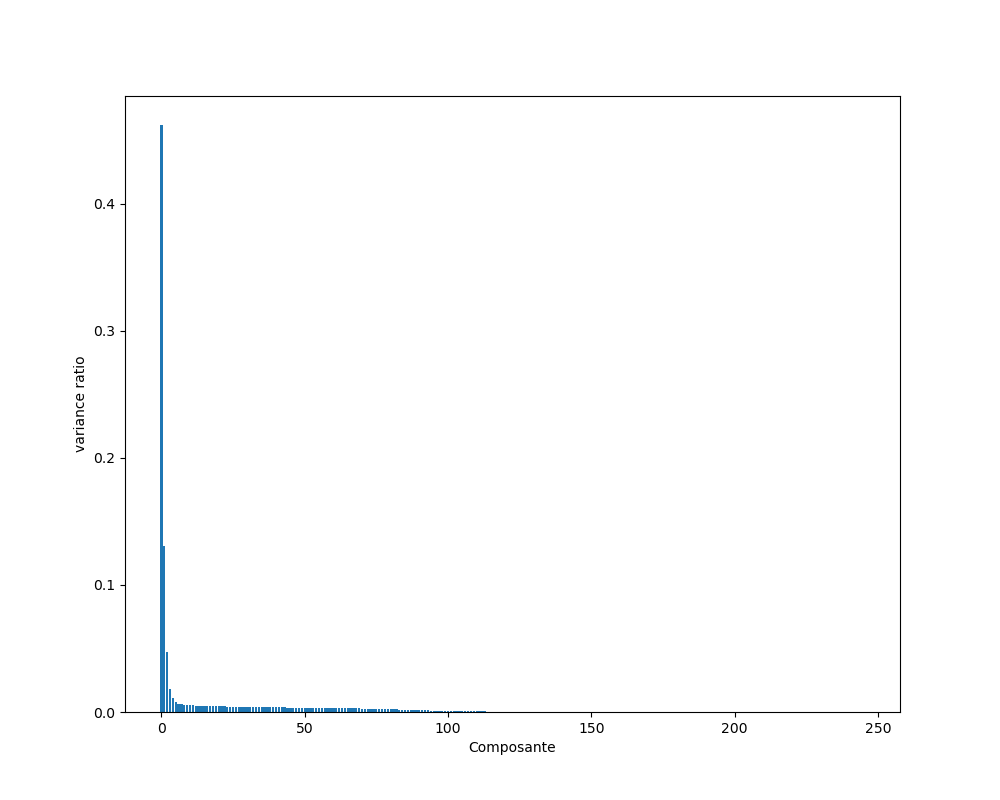

In [16]:
fig, ax = plt.subplots(figsize=(10,8))
var_ratio = pca.explained_variance_ratio_
ax.bar( range(len(var_ratio)), var_ratio )
ax.set_ylabel('variance ratio')
ax.set_xlabel('Composante')

Text(0, 0.8665112812938808, '0.87')

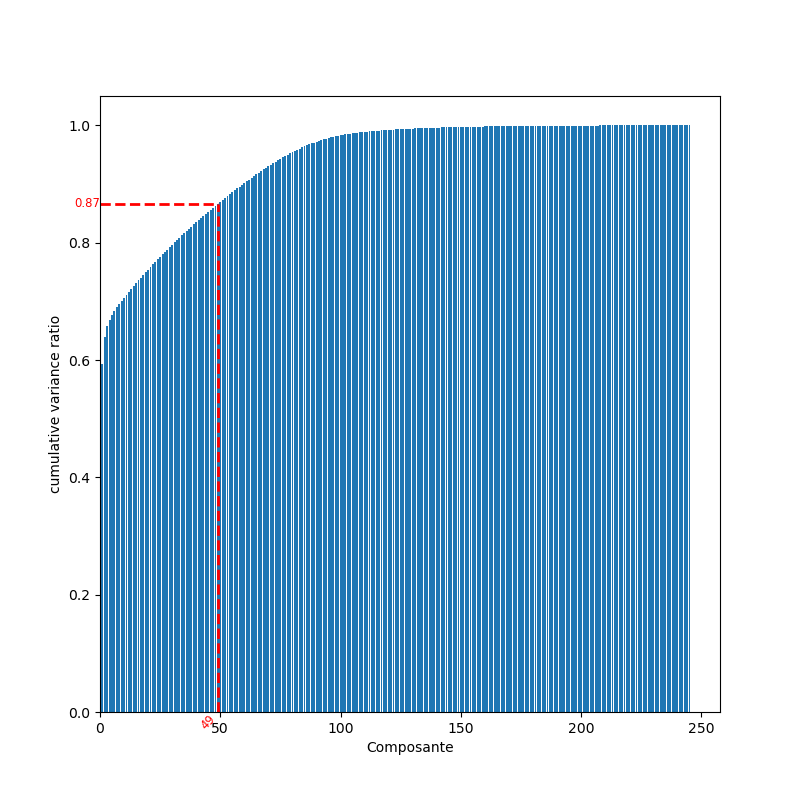

In [17]:
fig, ax = plt.subplots(figsize=(8,8))

ax.bar( range(len(var_ratio)), np.cumsum(var_ratio) )
ax.set_ylabel('cumulative variance ratio')
ax.set_xlabel('Composante')
ax.set_xlim(xmin=0)

ndim_after_pca = 50
var_ratio_tot = np.cumsum(var_ratio)[ndim_after_pca-1]

ax.plot([ndim_after_pca-1, ndim_after_pca-1], [0, var_ratio_tot], color='red', linestyle='--', linewidth=2)
ax.plot([0, ndim_after_pca-1], [var_ratio_tot, var_ratio_tot], color='red', linestyle='--', linewidth=2)
plt.text(ndim_after_pca-1, 0, f'{ndim_after_pca-1}', color='red', horizontalalignment='right', verticalalignment='top', rotation=45, fontsize='small')
plt.text(0, var_ratio_tot, f'{var_ratio_tot:.2f}', color='red', horizontalalignment='right', verticalalignment='center', fontsize='small')



In [18]:
df_reduced = new_feats[:, :ndim_after_pca]

## TSNE
Tips: https://lvdmaaten.github.io/tsne/

In [19]:
tsne = TSNE(n_components=3, perplexity=50)
X_embedded = tsne.fit_transform(df_reduced)
#X_embedded = tsne.fit_transform(df_scaled)

Text(0, 0.5, 'Variable 2')

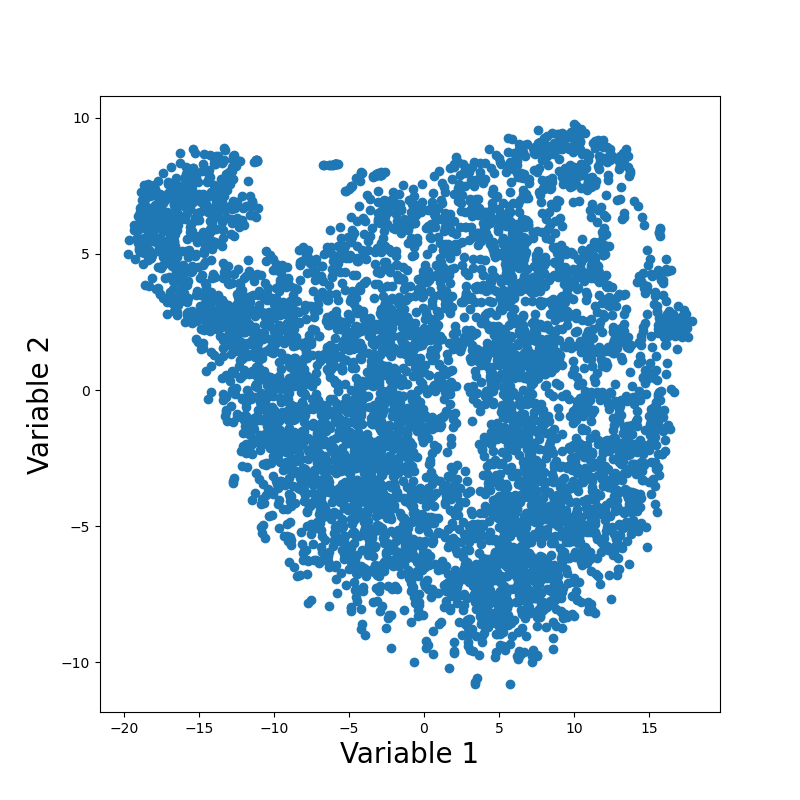

In [20]:
plt.figure(figsize=(8,8))
plt.scatter(X_embedded[:,0], X_embedded[:,1])
plt.xlabel('Variable 1', fontsize=20)
plt.ylabel('Variable 2', fontsize=20)
#plt.legend()
#plt.savefig('/home/thmegy/Documents/reports/Images/limagrain/tsne_fertile_sterile.png')

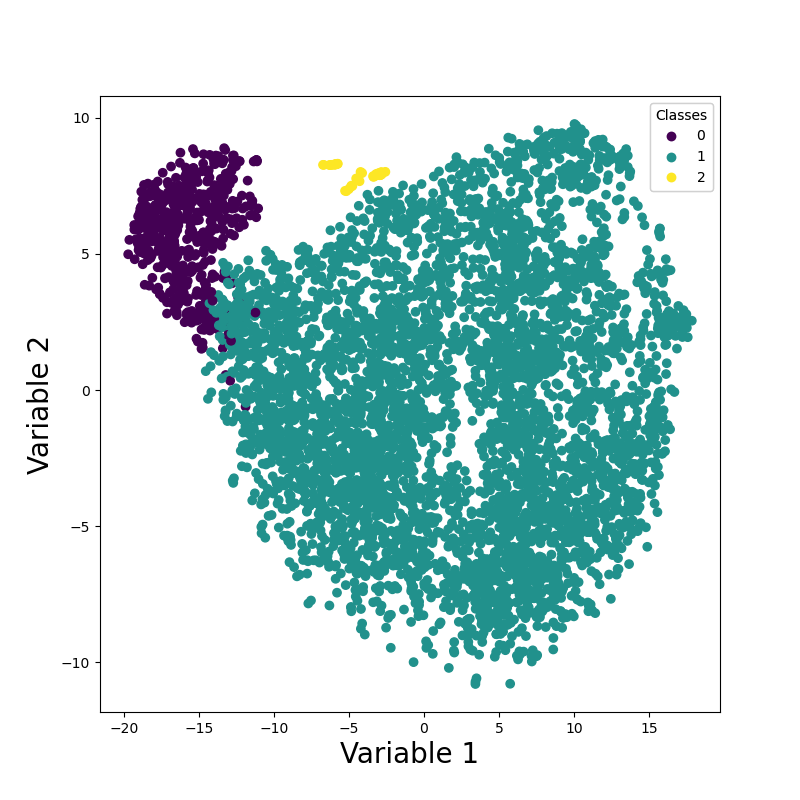

In [27]:
#clustering = DBSCAN(eps=2, min_samples=10).fit(X_embedded)
#clustering = KMeans(n_clusters=3).fit(X_embedded)
clustering = SpectralClustering(n_clusters=3,
        assign_labels='discretize',
        random_state=0).fit(X_embedded)

fig, ax = plt.subplots(figsize=(8,8))
scatter = ax.scatter(X_embedded[:,0], X_embedded[:,1], c=clustering.labels_)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
ax.set_xlabel('Variable 1', fontsize=20)
ax.set_ylabel('Variable 2', fontsize=20)
plt.savefig('/home/thmegy/Documents/Reports/Images/limagrain_2024/tsne_dbscan_2d.png')

In [22]:
tsne.kl_divergence_

1.4639499187469482

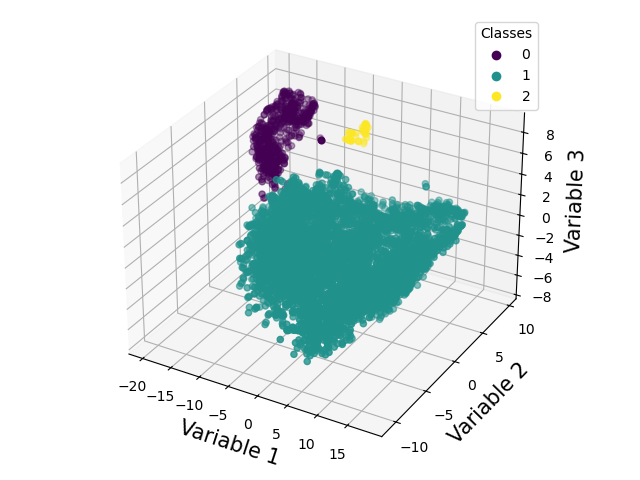

In [54]:
fig = plt.figure()
ax = plt.axes(projection='3d')
scatter = ax.scatter3D(X_embedded[:,0], X_embedded[:,1], X_embedded[:,2], c=clustering.labels_)
ax.set_xlabel('Variable 1', fontsize=15)
ax.set_ylabel('Variable 2', fontsize=15)
ax.set_zlabel('Variable 3', fontsize=15)
ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
plt.tight_layout()

On visualise les lots desquels proviennent les graines :

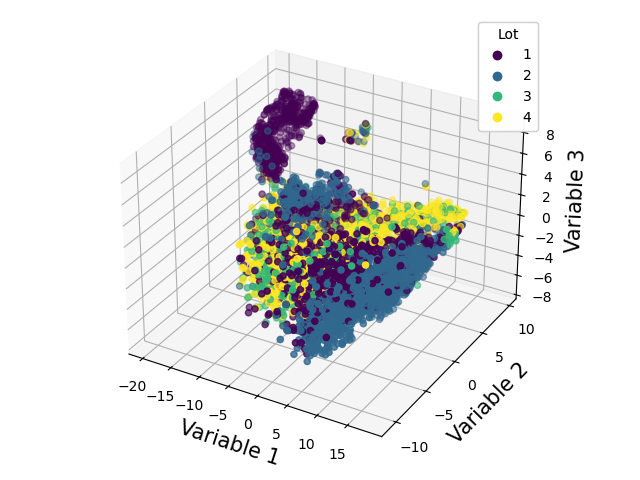

In [53]:
fig = plt.figure()
ax = plt.axes(projection='3d')
scatter = ax.scatter3D(X_embedded[:,0], X_embedded[:,1], X_embedded[:,2], c=df_viz['Lot'])
ax.set_xlabel('Variable 1', fontsize=15)
ax.set_ylabel('Variable 2', fontsize=15)
ax.set_zlabel('Variable 3', fontsize=15)

legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Lot")
ax.add_artist(legend1)
plt.tight_layout()

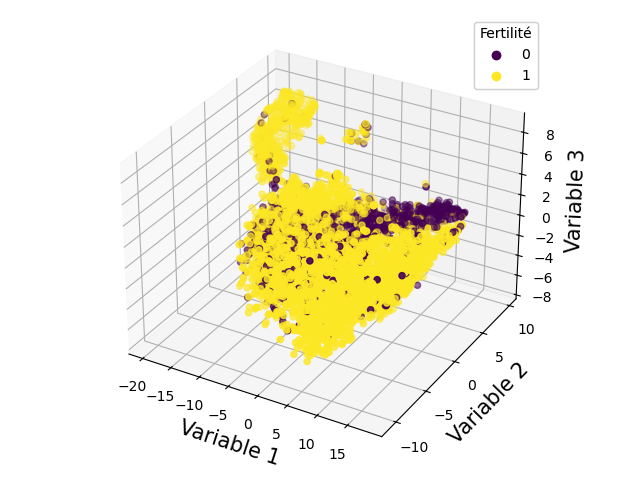

In [56]:
fig = plt.figure()
ax = plt.axes(projection='3d')
scatter = ax.scatter3D(X_embedded[:,0], X_embedded[:,1], X_embedded[:,2], c=df_viz['Fertilité'])
ax.set_xlabel('Variable 1', fontsize=15)
ax.set_ylabel('Variable 2', fontsize=15)
ax.set_zlabel('Variable 3', fontsize=15)

legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Fertilité")
ax.add_artist(legend1)
plt.tight_layout()

## Cross-check with spectral embbeding and Isomap

Text(0, 0.5, 'Variable 2')

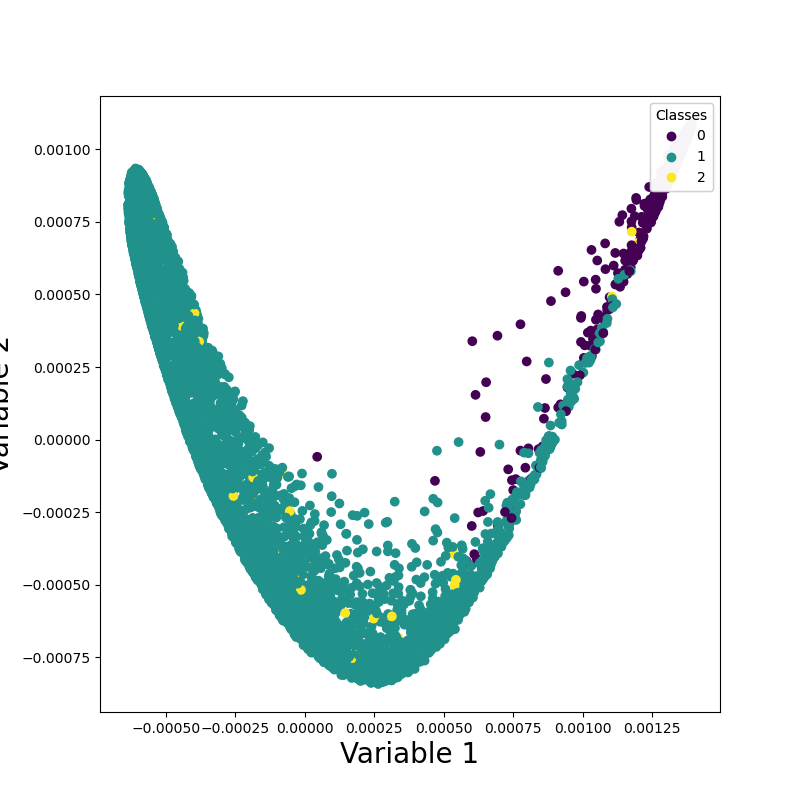

In [222]:
from sklearn.manifold import SpectralEmbedding
embedding = SpectralEmbedding(n_components=3)
X_transformed = embedding.fit_transform(df_scaled)

fig, ax = plt.subplots(figsize=(8,8))
scatter = ax.scatter(X_transformed[:,0], X_transformed[:,1], c=clustering.labels_)
#plt.scatter(X_transformed[:,0], X_transformed[:,1], c=y)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
ax.set_xlabel('Variable 1', fontsize=20)
ax.set_ylabel('Variable 2', fontsize=20)
#plt.savefig('/home/thmegy/Documents/reports/Images/limagrain/spectral_tsne_dbscan.png')

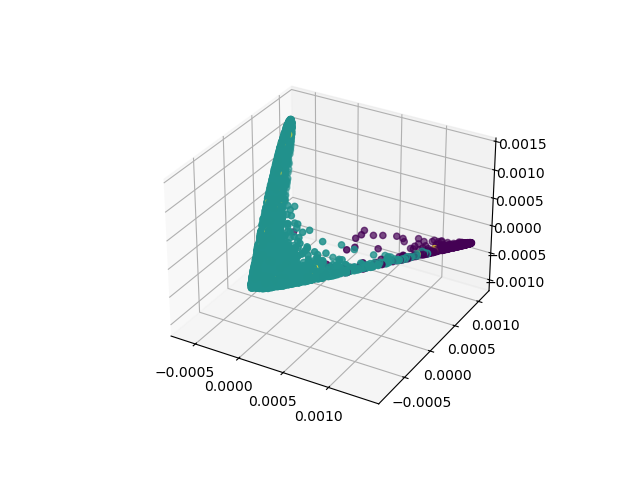

In [223]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X_transformed[:,0], X_transformed[:,1], X_transformed[:,2], c=clustering.labels_);

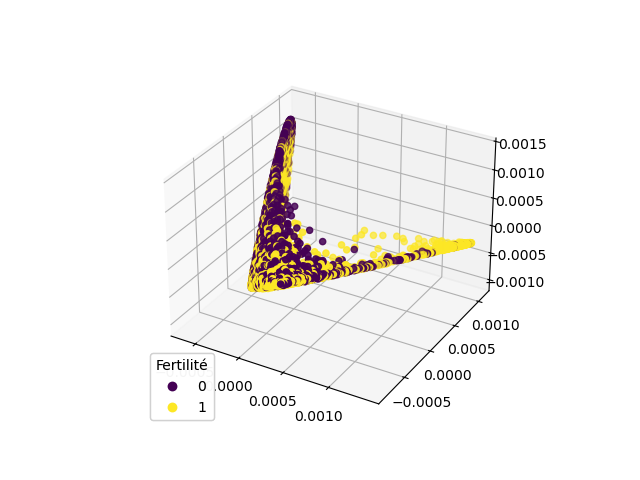

In [225]:
fig = plt.figure()
ax = plt.axes(projection='3d')
scatter = ax.scatter3D(X_transformed[:,0], X_transformed[:,1], X_transformed[:,2], c=df_viz['Fertilité'])

legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title="Fertilité")
ax.add_artist(legend1)


Text(0, 0.5, 'Variable 2')

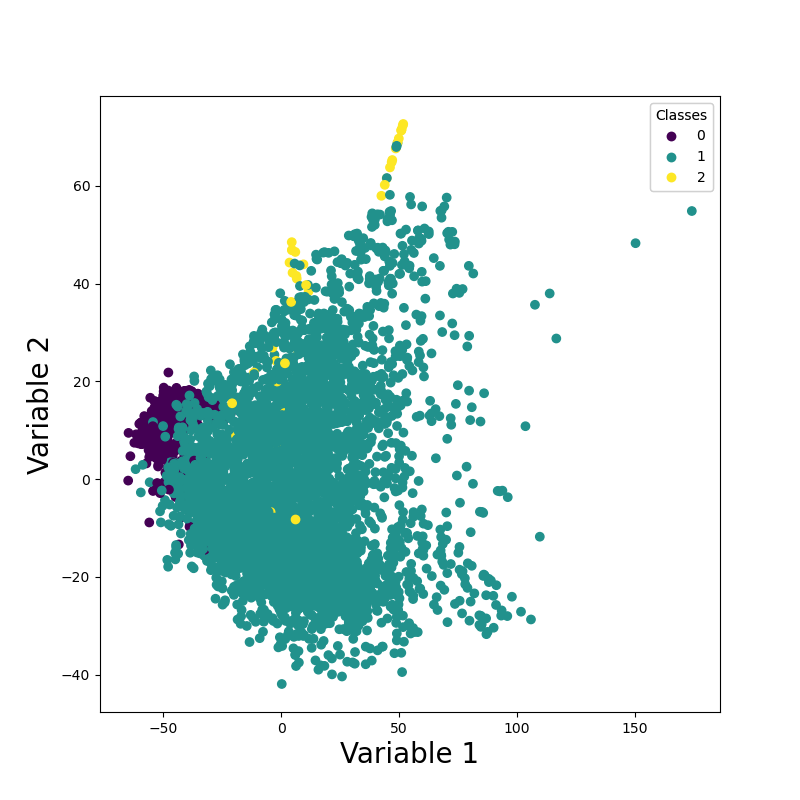

In [226]:
from sklearn.manifold import Isomap
embedding = Isomap(n_components=3)
X_transformed = embedding.fit_transform(df_scaled)

fig, ax = plt.subplots(figsize=(8,8))
scatter = ax.scatter(X_transformed[:,0], X_transformed[:,1], c=clustering.labels_)
#plt.scatter(X_transformed[:,0], X_transformed[:,1], c=y)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
ax.set_xlabel('Variable 1', fontsize=20)
ax.set_ylabel('Variable 2', fontsize=20)
#plt.savefig('/home/thmegy/Documents/reports/Images/limagrain/isomap_tsne_dbscan.png')

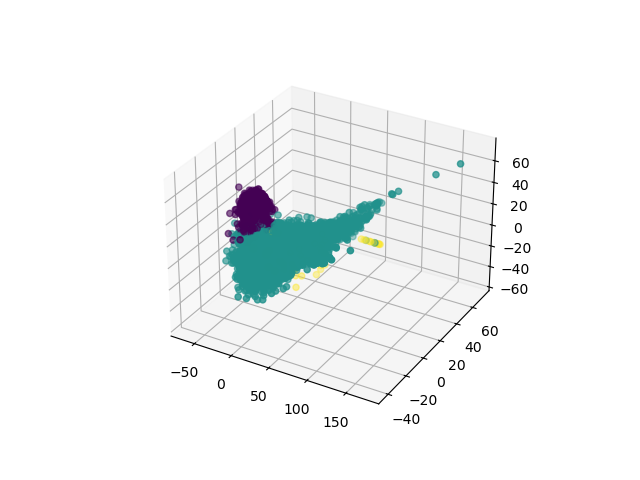

In [227]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X_transformed[:,0], X_transformed[:,1], X_transformed[:,2], c=clustering.labels_);

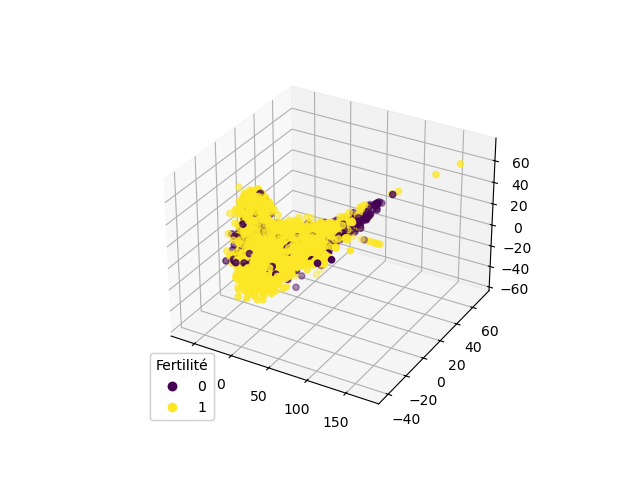

In [228]:
fig = plt.figure()
ax = plt.axes(projection='3d')
scatter = ax.scatter3D(X_transformed[:,0], X_transformed[:,1], X_transformed[:,2], c=df_viz['Fertilité'])

legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title="Fertilité")
ax.add_artist(legend1)


## Explore differences between clusters

In [41]:
diff_cluster_1_vs_0 = (df_scaled[clustering.labels_ == 1].mean() - df_scaled[clustering.labels_ == 0].mean())
diff_cluster_1_vs_0.abs().sort_values()[-30:-1]

HYPVIS_700.2nm    1.724381
HYPVIS_697.5nm    1.734389
HYPVIS_694.8nm    1.735344
HYPVIS_598.3nm    1.741216
HYPVIS_641.2nm    1.743848
HYPVIS_601.0nm    1.758935
HYPVIS_681.4nm    1.758947
HYPVIS_686.8nm    1.766894
HYPVIS_692.1nm    1.767513
HYPVIS_689.4nm    1.775496
HYPVIS_684.1nm    1.778639
HYPVIS_678.7nm    1.783066
HYPVIS_673.4nm    1.783638
HYPVIS_611.7nm    1.789739
HYPVIS_676.0nm    1.790530
HYPVIS_670.7nm    1.795498
HYPVIS_643.9nm    1.807997
HYPVIS_668.0nm    1.808412
HYPVIS_603.7nm    1.811327
HYPVIS_665.3nm    1.819335
HYPVIS_609.0nm    1.825170
HYPVIS_606.4nm    1.830771
HYPVIS_662.6nm    1.843340
HYPVIS_660.0nm    1.860707
HYPVIS_646.6nm    1.866262
HYPVIS_649.2nm    1.891979
HYPVIS_657.3nm    1.901497
HYPVIS_654.6nm    1.910487
HYPVIS_651.9nm    1.923367
dtype: float64

In [42]:
diff_cluster_2_vs_0 = (df_scaled[clustering.labels_ == 2].mean() -
                       df_scaled[clustering.labels_ == 0].mean())
diff_cluster_2_vs_0.abs().sort_values()

HYPVIS_400.0nm    0.099824
X_Ray_Size        0.197348
HYPVIS_531.3nm    0.221187
HYPVIS_472.4nm    0.271038
HYPVIS_453.6nm    0.290902
                    ...   
AvgL              4.024098
VIS_FeretMin      4.531378
VIS_FShape        5.481378
VIS_LShape        6.715548
VIS_Convexity     8.139942
Length: 246, dtype: float64

In [43]:
hypvis_cols = df_scaled.columns[23:].tolist()
hypvis_wavelengths = [float(h[-7:-2]) for h in hypvis_cols]

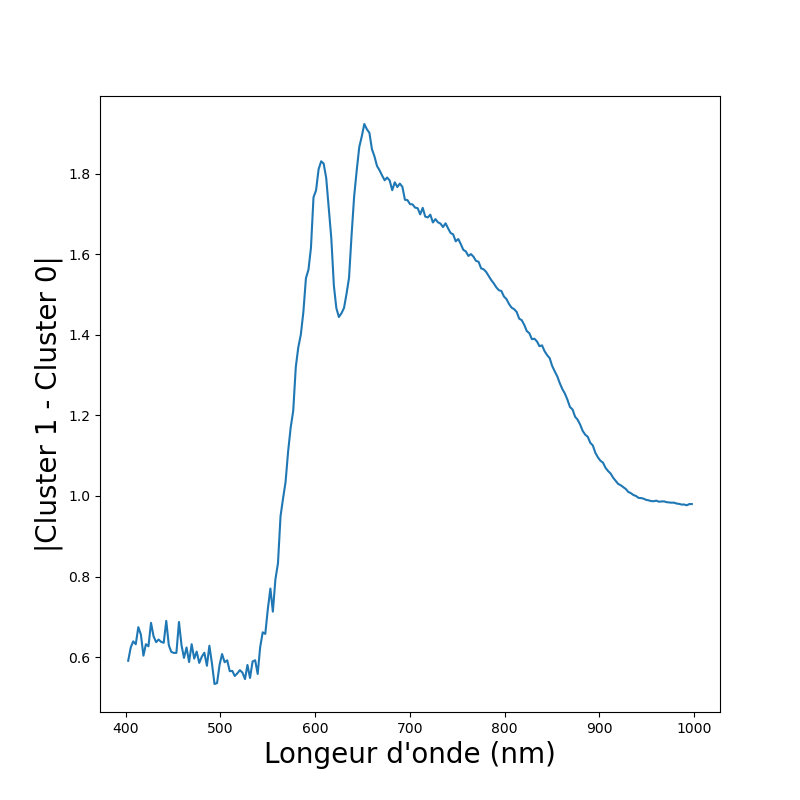

In [48]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(hypvis_wavelengths, diff_cluster_1_vs_0[hypvis_cols])
ax.set_xlabel('Longeur d\'onde (nm)', fontsize=20)
ax.set_ylabel('|Cluster 1 - Cluster 0|', fontsize=20)
plt.savefig('/home/thmegy/Documents/Reports/Images/limagrain_2024/diff_clusters_vs_wavelength.png')

# Méthodes supervisées

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression
import shap

In [15]:
# get train/val split used to train the Neural Network on images
with open('../data/data_limagrain_2024/split_train_val_NN_raw_images.json') as f:
    train_val_dict = json.load(f)
train_NN = train_val_dict['train']
val_NN = train_val_dict['val']
len(train_val_dict['train']) + len(train_val_dict['val'])

6732

In [16]:
# compare available seeds with excel file and raw images
seeds_excel = ('OSR' + df_viz['Lot'].astype('str') + '_' + df_viz['ID']).tolist()
print(len(seeds_excel))
seeds_images = train_NN + val_NN
print(len(seeds_images))

intersection = [value for value in seeds_images if value in seeds_excel]
print(len(intersection))

diff = [value for value in seeds_images if value not in seeds_excel]

6187
6732
6187


In [17]:
mask_train = ('OSR' + df_viz['Lot'].astype('str') + '_' + df_viz['ID']).isin(train_NN)
mask_val = ('OSR' + df_viz['Lot'].astype('str') + '_' + df_viz['ID']).isin(val_NN)

In [18]:
# remove hyperspectral data --> above index 22
#x_train, x_test, df_train, df_test = train_test_split(df.iloc[:,:22], df_viz, test_size = 0.30)

In [79]:
# split train and val like in NN training
x_train = df[mask_train]
x_test = df[mask_val]
df_train = df_viz[mask_train]
df_test = df_viz[mask_val]

In [80]:
df_train.head()

,Lot,CYTOPLASME,RF,Fertilité,ID
1,1,0,1,1,T01_A04
2,1,0,1,1,T01_A05
7,1,0,1,1,T01_A10
10,1,0,1,1,T01_B12
11,1,0,1,1,T01_B11


In [81]:
# Choose the variable to use as label
label = 'Fertilité'
y_train = df_train[label]
y_test = df_test[label]

In [82]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([ 516, 1351]))

In [132]:
for lot in np.unique(df_train['Lot']):
    mask_lot = df_train['Lot']==lot
    print(np.unique(y_train[mask_lot], return_counts=True))
    
    mask_lot = df_test['Lot']==lot
    print(np.unique(y_test[mask_lot], return_counts=True))
    
    print('')

(array([0, 1]), array([  33, 1069]))
(array([0, 1]), array([ 10, 455]))

(array([0, 1]), array([  34, 1122]))
(array([0, 1]), array([ 10, 464]))

(array([0, 1]), array([449, 393]))
(array([0, 1]), array([202, 165]))

(array([0, 1]), array([630, 590]))
(array([0, 1]), array([294, 267]))



In [159]:
630+294

924

In [83]:
# Scale data
scaler = preprocessing.StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns)

x_test_scaled = scaler.transform(x_test)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test.columns)

## Random forest

In [162]:
def train_random_forest(X_train, Y_train, X_test, Y_test, cols):
    X_train = X_train[cols]
    X_test = X_test[cols]
    
    mask_lot = (df_test['Lot']==lot).to_numpy()
    X_test = X_test[mask_lot]
    Y_test = Y_test[mask_lot]
    
    clf = RandomForestClassifier(n_estimators = 1000, class_weight='balanced') 
    clf.fit(X_train, Y_train)
    
    Y_pred = clf.predict(X_test)
    print(metrics.accuracy_score(Y_test, Y_pred))
    for i in np.unique(Y_test):
        mask = Y_test == i
        print( f'class {i} : {metrics.accuracy_score(Y_test[mask], Y_pred[mask]):.3f}' )
        
    print(metrics.confusion_matrix(Y_test, Y_pred))
        
    precision_f, recall_f, thrs = metrics.precision_recall_curve(Y_test, clf.predict_proba(X_test)[:,1])
    
    return clf, precision_f, recall_f

In [163]:
cols_all = ['X_Ray_Size', 'VIS_Major', 'VIS_Minor',
       'VIS_LShape', 'VIS_Perimeter', 'VIS_HullArea', 'VIS_HullPeri',
       'VIS_Convexity', 'VIS_FeretMax', 'VIS_FeretMin', 'VIS_FShape', 'CF_Size', 'CF_Avg']
cols_xray = ['X_Ray_Size']
cols_vis = ['VIS_Major', 'VIS_Minor',
       'VIS_LShape', 'VIS_Perimeter', 'VIS_HullArea', 'VIS_HullPeri',
       'VIS_Convexity', 'VIS_FeretMax', 'VIS_FeretMin', 'VIS_FShape']
cols_cf = ['CF_Size', 'CF_Avg']
cols_other = ['Absorption', 'Size', 'AvgL', 'AvgA', 'AvgB', 'HSV_Size', 'HSV_Width', 'HSV_Height', 'HSV_MaxVal']

In [164]:
clf_all, precision_all, recall_all = train_random_forest(x_train_scaled, y_train, x_test_scaled, y_test, cols_all+cols_other)

0.8716577540106952
class 0 : 0.884
class 1 : 0.858
[[260  34]
 [ 38 229]]


In [165]:
clf_xray, precision_xray, recall_xray = train_random_forest(x_train_scaled, y_train, x_test_scaled, y_test, cols_xray)

0.5525846702317291
class 0 : 0.561
class 1 : 0.543
[[165 129]
 [122 145]]


In [166]:
clf_vis, precision_vis, recall_vis = train_random_forest(x_train_scaled, y_train, x_test_scaled, y_test, cols_vis)

0.6684491978609626
class 0 : 0.609
class 1 : 0.734
[[179 115]
 [ 71 196]]


In [167]:
clf_cf, precision_cf, recall_cf = train_random_forest(x_train_scaled, y_train, x_test_scaled, y_test, cols_cf)

0.7058823529411765
class 0 : 0.687
class 1 : 0.727
[[202  92]
 [ 73 194]]


In [168]:
clf_other, precision_other, recall_other = train_random_forest(x_train_scaled, y_train, x_test_scaled, y_test, cols_other)

0.8324420677361853
class 0 : 0.827
class 1 : 0.839
[[243  51]
 [ 43 224]]


Text(0, 0.5, 'precision')

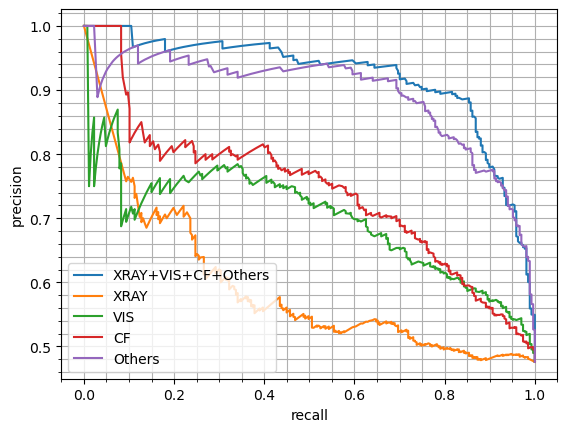

In [169]:
plt.plot(recall_all, precision_all, label='XRAY+VIS+CF+Others')
plt.plot(recall_xray, precision_xray, label='XRAY')
plt.plot(recall_vis, precision_vis, label='VIS')
plt.plot(recall_cf, precision_cf, label='CF')
plt.plot(recall_other, precision_other, label='Others')

plt.minorticks_on()
plt.grid(which='both')
plt.legend()
plt.xlabel('recall')
plt.ylabel('precision')
#plt.savefig('/home/thmegy/Documents/Reports/Images/limagrain_2024/precision_recall_fertile_RF_breakdown.png')

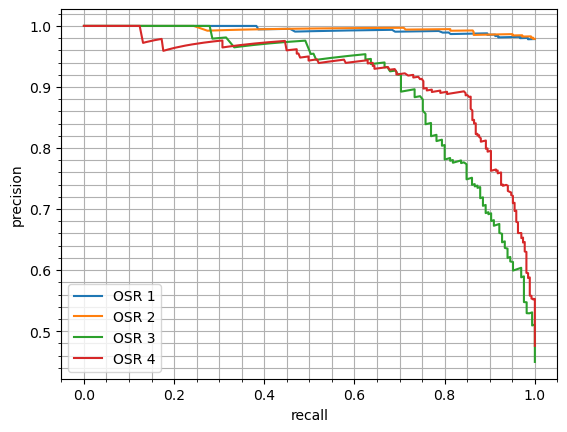

In [152]:
for lot in np.unique(df_train['Lot']):
    mask_lot = (df_test['Lot']==lot).to_numpy()
    X_test = x_test_scaled[cols_all+cols_other][mask_lot]
    p, r, _ = metrics.precision_recall_curve(y_test[mask_lot], clf_all.predict_proba(X_test)[:,1])
    plt.plot(r, p, label=f'OSR {lot}')
    
plt.minorticks_on()
plt.grid(which='both')
plt.legend()
plt.xlabel('recall')
plt.ylabel('precision')
plt.savefig('/home/thmegy/Documents/Reports/Images/limagrain_2024/precision_recall_fertile_RF_lots.png')

In [60]:
explainer = shap.TreeExplainer(clf)

In [61]:
shap_values = explainer(x_test_scaled.iloc[:200,:])

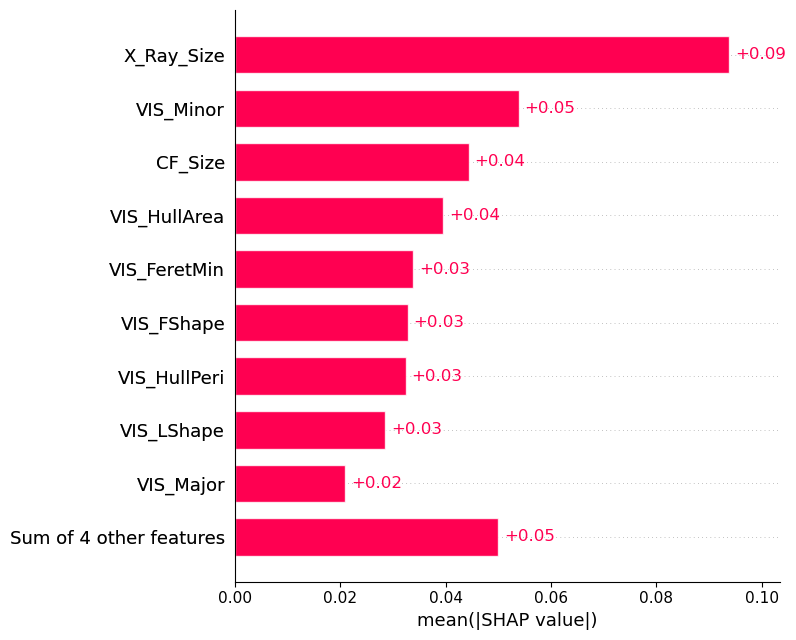

In [62]:
shap.plots.bar(shap_values[:,:,1], show=False)
plt.tight_layout()
plt.savefig('/home/thmegy/Documents/Reports/Images/limagrain_2024/shap_bar_mean.png')

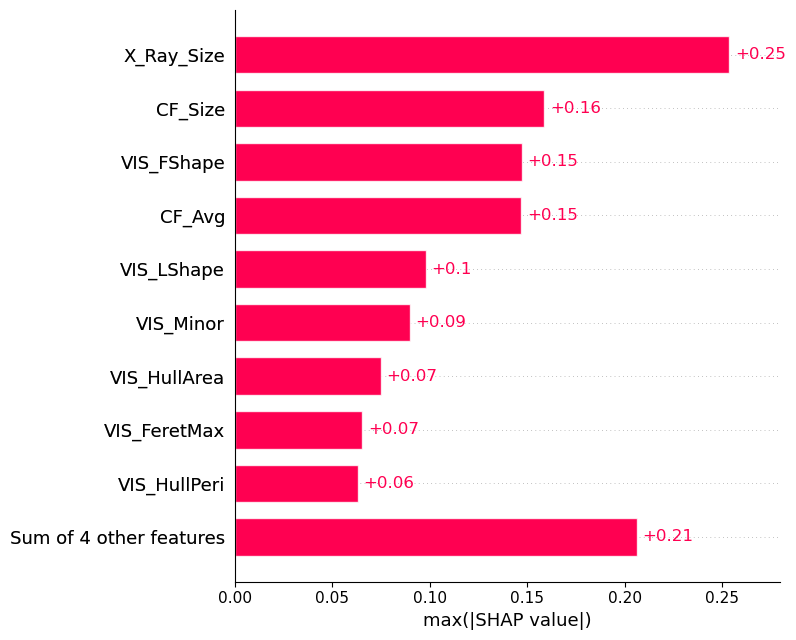

In [63]:
shap.plots.bar(shap_values[:,:,1].abs.max(0), show=False)
plt.tight_layout()
plt.savefig('/home/thmegy/Documents/Reports/Images/limagrain_2024/shap_bar_max.png')

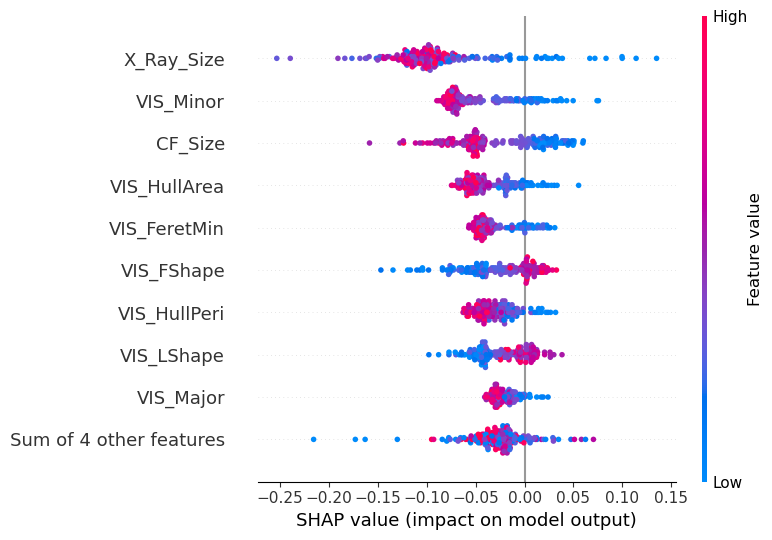

In [64]:
shap.plots.beeswarm(shap_values[:,:,0], show=False)
plt.tight_layout()
plt.savefig('/home/thmegy/Documents/Reports/Images/limagrain_2024/shap_impact.png')

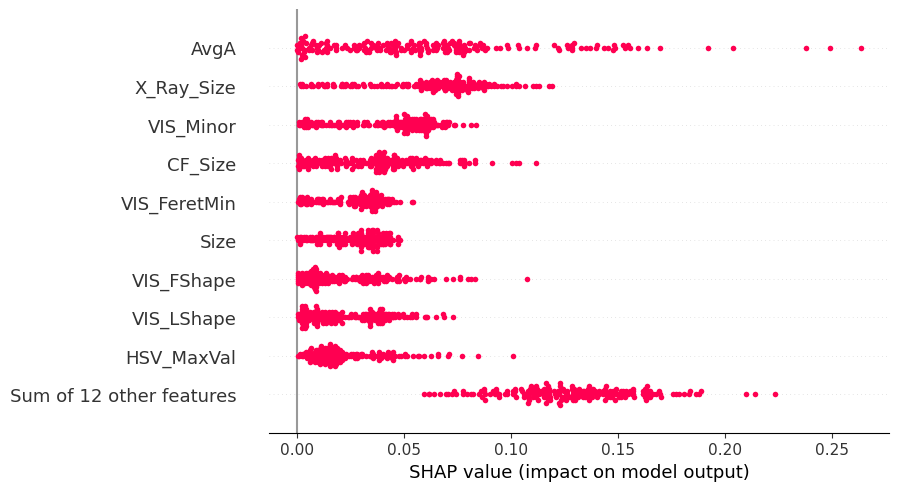

In [44]:
shap.plots.beeswarm(shap_values[:,:,1].abs, color="shap_red")

## plot NN results

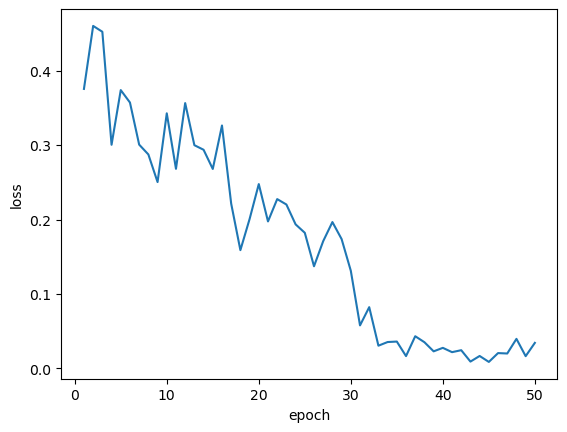

In [39]:
# loss
with open('../data/data_limagrain_2024/loss_NN_raw_images.json') as f:
    epochs = json.load(f)['test']

loss_list = []
epoch_list = []
for e in epochs:
    try:
        loss_list.append(e['loss'])
        epoch_list.append(e['epoch'])
    except:
        pass

plt.plot(epoch_list, loss_list)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('/home/thmegy/Documents/Reports/Images/limagrain_2024/loss_resnet.png')

In [115]:
# precision recall
with open('../data/data_limagrain_2024/results_NN_raw_images.json') as f:
    res = json.load(f)
with open('../data/data_limagrain_2024/results_NN_raw_images_xray.json') as f:
    res_xray = json.load(f)
with open('../data/data_limagrain_2024/results_NN_raw_images_cf.json') as f:
    res_cf = json.load(f)
with open('../data/data_limagrain_2024/results_NN_raw_images_vis.json') as f:
    res_vis = json.load(f)

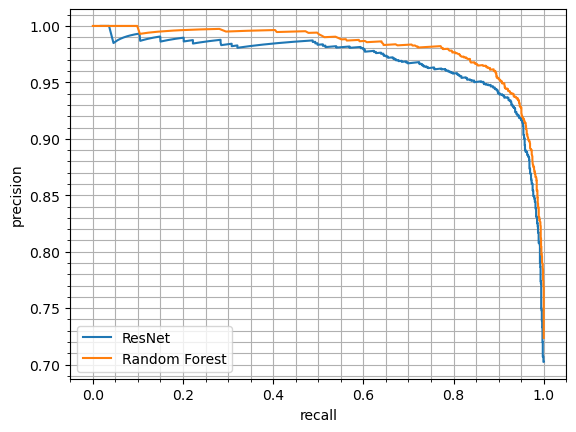

In [127]:
plt.plot(res['Fertile']['recall'], res['Fertile']['precision'], label='ResNet')
plt.plot(recall_all, precision_all, label='Random Forest')
plt.minorticks_on()
plt.grid(which='both')
plt.legend()
plt.xlabel('recall')
plt.ylabel('precision')
plt.savefig('/home/thmegy/Documents/Reports/Images/limagrain_2024/precision_recall_fertile.png')

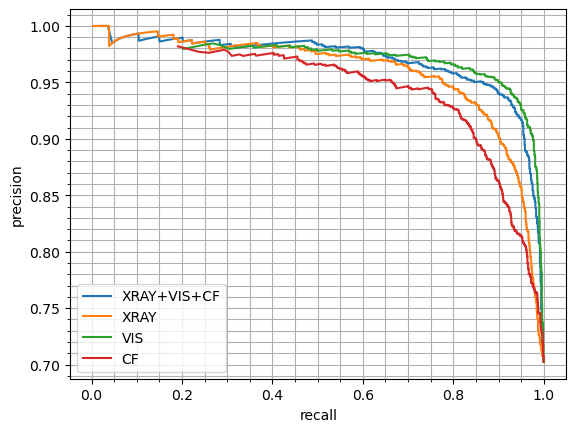

In [117]:
plt.plot(res['Fertile']['recall'], res['Fertile']['precision'], label='XRAY+VIS+CF')
plt.plot(res_xray['Fertile']['recall'], res_xray['Fertile']['precision'], label='XRAY')
plt.plot(res_vis['Fertile']['recall'], res_vis['Fertile']['precision'], label='VIS')
plt.plot(res_cf['Fertile']['recall'], res_cf['Fertile']['precision'], label='CF')
plt.minorticks_on()
plt.grid(which='both')
plt.legend()
plt.xlabel('recall')
plt.ylabel('precision')
plt.savefig('/home/thmegy/Documents/Reports/Images/limagrain_2024/precision_recall_fertile_NN_breakdown.png')